# Visualise feature set distributions

The purpose of this notebook is to visualise the distribution of feature set values. For each feture set, I will produce a plot showing the relative porpotions of values:
1. for all patients, 
2. for cases, _and_
3. for controls.

For logic-valued feature sets  - i.e. {True, False} - and categoriecal feature sets, I will use column charts to display proportions. The proportions for  cases and controls will be overlaid upon the proportion for all patients.

For continuous-valued feature sets, I will use histograms with feature-set-specific bin widths, with the histogram for all patients in the background, for caseses in the midground, and for controls in the foreground.

## Imports and helper functions

In [206]:
%run 'UNSEEN_helper_functions.ipynb'
%store -r

## ###TEMP### Retrieve all feature sets that are boolean (i.e. True/False for the presence of the feature set)
(note: This bit will later be removed once I have completed the discretisation of the continuous-valued feature sets.)

In [207]:
fs_boolean = feature_set_array.loc[:,feature_set_array.dtypes == 'bool']

## ###TEMP### Retrieve all feature sets that are float64 (i.e. continous valued)

In [208]:
fs_continuous = feature_set_array.loc[:,feature_set_array.dtypes == 'float64']

## Apply redaction and rounding rules to avoid disclosivity

In [209]:
# Display message.
display(
    Markdown(
f"""
Any feature set with a category count less than or equal to {redaction_threshold} are redacted. All remaining feature-set category counts are rounded to the nearest {target_round}.
"""
       )
)
# Redaction.
fs_redacted = fs_boolean.loc[:,fs_boolean.sum() > redaction_threshold]
# Rounding.
denominator_overall = round(len(caseness_array) / target_round) * target_round
denominator_caseness = round(sum(caseness_array.caseness_1isYes == 1) / target_round) * target_round
denominator_controls = round(sum(caseness_array.caseness_1isYes != 1) / target_round) * target_round
# NOTE: numerators will be rounded during the data-processing steps of the visualisation.


Any feature set with a category count less than or equal to 7 are redacted. All remaining feature-set category counts are rounded to the nearest 10.


## Prepare categorical data for plotting

The code below accepts a pandas.DataFrame of feature-set values and produces a 3-part visualisation for each:
1. A column chart showing the proportions of patients with each of the categorical feature-set values, colour coded by patient group.
2. A column chart showing the proportions of patients within each of the patient groups, colour coded by feature set value.
3. A table showing the proportions of patients in each patient group that have each feature-set value. Rows sum to 1.00.

In [210]:
# Instantiate variables.
myPlotDataOverall = []
myPlotDataOverall_labels = []
myPlotDataCaseness = []
myPlotDataCaseness_labels = []
myPlotDataControls = []
myPlotDataControls_labels = []

# Set save location.
plot_dir = pathlib.Path(os.getcwd() + '/Plots/Descriptives/')

for i_col in range(len(fs_redacted.columns)):
    # Get set of values that are in the column.
    colVals = sorted(fs_redacted.iloc[:,i_col].unique())
    
    # Count the occurence of each unique value, overall.
    ls_vals = []
    ls_vals_labels = []
    for i_val in colVals:
        rounded_value = \
            round(
                # Rounding to avoid disclosivity.
                round( sum(fs_redacted.iloc[:,i_col] == i_val) / target_round) * target_round
                / denominator_overall
                , 2
            )
        ls_vals.append(rounded_value)
        ls_vals_labels.append( '< 0.01' if rounded_value == 0 else '> 0.99' if rounded_value == 1 else rounded_value )
    myPlotDataOverall.append(ls_vals)
    myPlotDataOverall_labels.append(ls_vals_labels)
    
    # Count the occurence of each unique value, for cases and for controls.
    ls_vals_caseness = []
    ls_vals_caseness_labels = []
    ls_vals_controls = []
    ls_vals_controls_labels = []
    for i_val in colVals:
        fs_present = fs_redacted.iloc[:,i_col] == i_val
        caseness_present = caseness_array.caseness_1isYes == 1
        combined = pandas.concat([fs_present, caseness_present], axis = 1)
        rounded_value = \
            round(
                # Rounding to avoid disclosivity.
                round( sum(combined.sum(axis=1) == 2) / target_round) * target_round
                / denominator_caseness
                , 2
            )
        ls_vals_caseness.append(rounded_value)
        ls_vals_caseness_labels.append( '< 0.01' if rounded_value == 0 else '> 0.99' if rounded_value == 1 else rounded_value )
        
        control_present = caseness_array.caseness_1isYes != 1
        combined = pandas.concat([fs_present, control_present], axis = 1)
        rounded_value = \
            round(
                round( sum(combined.sum(axis=1) == 2) / target_round) * target_round 
                / denominator_controls
                , 2
            )
        ls_vals_controls.append(rounded_value)
        ls_vals_controls_labels.append( '< 0.01' if rounded_value == 0 else '> 0.99' if rounded_value == 1 else rounded_value )
    myPlotDataCaseness.append(ls_vals_caseness)
    myPlotDataCaseness_labels.append(ls_vals_caseness_labels)
    myPlotDataControls.append(ls_vals_controls)
    myPlotDataControls_labels.append(ls_vals_controls_labels)

# Combine each feature sets' tuples from the 'overall', 'caseness', and 'controls' plot data.
myData = list(map(list, zip(*[ myPlotDataOverall, myPlotDataCaseness, myPlotDataControls ])))
myData_labels = list(map(list, zip(*[ myPlotDataOverall_labels, myPlotDataCaseness_labels, myPlotDataControls_labels ])))

# Plot the visualisations for each feature set
for i_fs in range(len(fs_redacted.columns)):
    fig, axs = matplotlib.pyplot.subplots(1, 3, figsize = (12,4),  gridspec_kw={'width_ratios': [2, 2, 3]})
    matplotlib.pyplot.title('Feature set is\n\'' + fs_redacted.columns[i_fs] + '\'', fontsize = 20)
    # Plot distinguishing cohorts.
    fs_unique_values = sorted(fs_redacted.iloc[:,i_col].unique())
    ind1 = list(map(str, fs_unique_values))
    axs[0].bar(x = ind1, height = myData[i_fs][0], width = 0.6,   align='center')
    axs[0].bar(x = ind1, height = myData[i_fs][1], width = -0.2,  align='edge')
    axs[0].bar(x = ind1, height = myData[i_fs][2], width = 0.2,   align='edge')
    axs[0].legend(['All patients', 'Cases', 'Controls'])
    axs[0].set_xlabel('Feature set value')
    axs[0].set_ylabel('Proportion of patients')
    axs[0].set_ylim(0,1.2)
    
    # Plot distinguishing feature-set values.
    ind2 = ('All patients', 'Cases', 'Controls')
    axs[1].bar(x = ind2, height = list(map(list, zip(*myData[i_fs])))[0], width = -0.2,  align='edge')
    axs[1].bar(x = ind2, height = list(map(list, zip(*myData[i_fs])))[1], width = 0.2,   align='edge')
    axs[1].legend(fs_unique_values)
    axs[1].set_xlabel('Patient group')
    axs[1].set_ylabel('Proportion of patients')
    axs[1].set_ylim(0, 1.2)

    the_table = axs[2].table(cellText = list(map(list, zip(*myData_labels[i_fs]))),
                          colLabels = ind2,
                          rowLabels = ind1,
                          loc = 'center')
    the_table.scale(1,2)
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(15)
    axs[2].axis('off')
    matplotlib.pyplot.tight_layout()
    
    # Save figures.
    fig.savefig(f'{plot_dir}/{fs_redacted.columns[i_fs]}.png')
    matplotlib.pyplot.close(fig)

## Prepare continuous data for plotting

The code below accepts a pandas.DataFrame of feature-set values and produces a 2-part visualisation for each:
1. A histogram chart showing the distribution of patients' values, colour coded by patient group.
2. A table showing summary statistics of feature-set values, stratified by patient group.

In [211]:
for i_fs in fs_continuous.columns:
    fig, axs = matplotlib.pyplot.subplots(1, 2, figsize = (12, 4),  gridspec_kw={'width_ratios': [1.5, 1]})
    matplotlib.pyplot.title('Feature set is\n\'' + i_fs + '\'', fontsize = 20)
    # Plot histograms.
    axs[0].hist( fs_continuous[ i_fs ], label = 'All patients', density = True,
                align = 'mid',   bins = 'doane', histtype = 'step')
    axs[0].hist( fs_continuous.loc[ caseness_array.caseness_1isYes == 1, i_fs ], density = True,
                align = 'left',  bins = 'doane', label = 'Cases', alpha = 0.6)
    axs[0].hist( fs_continuous.loc[ caseness_array.caseness_1isYes == 0, i_fs ], density = True,
                align = 'right', bins = 'doane', label = 'Controls', alpha = 0.6)
    axs[0].legend(loc='upper right')
    axs[0].set_xlabel('Feature set value')
    axs[0].set_ylabel('Probability of patients\n having feature-set value')
    
    # Plot the table.
    summaryStats_overall = list(map(str, round(fs_continuous[i_fs].describe(), 2)[1:]))
    summaryStats_cases = list(map(str, round(fs_continuous.loc[ caseness_array.caseness_1isYes == 1, i_fs ].describe(), 2)[1:]))
    summaryStats_controls = list(map(str, round(fs_continuous.loc[ caseness_array.caseness_1isYes == 0, i_fs ].describe(), 2)[1:]))
    collabels = ('All patients', 'Cases', 'Controls')
    rowlabels = tuple(summaryStats.index)   
    the_table = axs[1].table(cellText =  list(map(list, zip(*[summaryStats_overall, summaryStats_cases, summaryStats_controls]))),
                             colLabels = collabels,
                             rowLabels = rowlabels,
                             loc = 'center')
    the_table.scale(1,2)
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(15)
    axs[1].axis('off')
    matplotlib.pyplot.tight_layout()
    
    # Save figures.
    fig.savefig(f'{plot_dir}/{i_fs}.png')
    matplotlib.pyplot.close(fig)

# Show plots

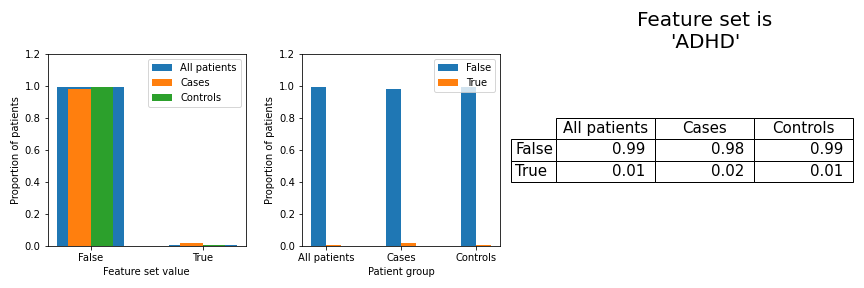

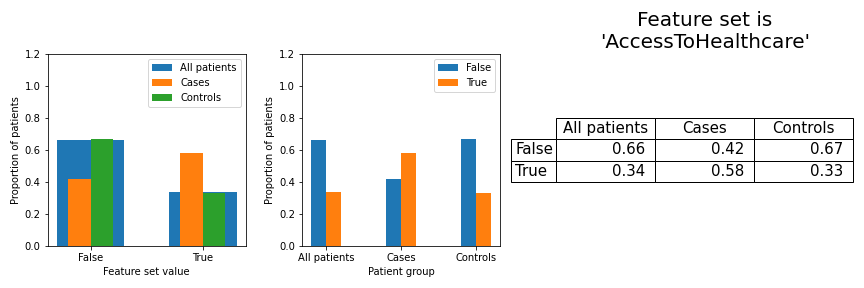

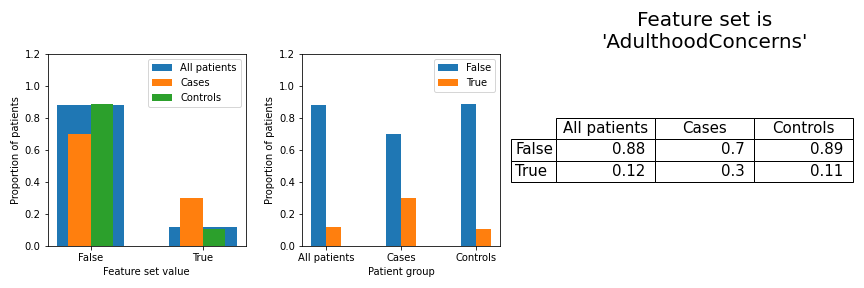

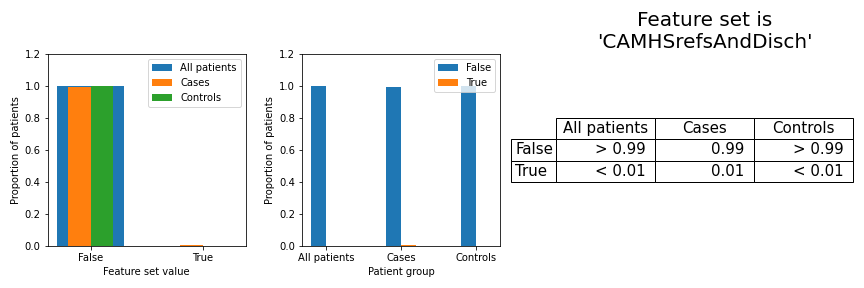

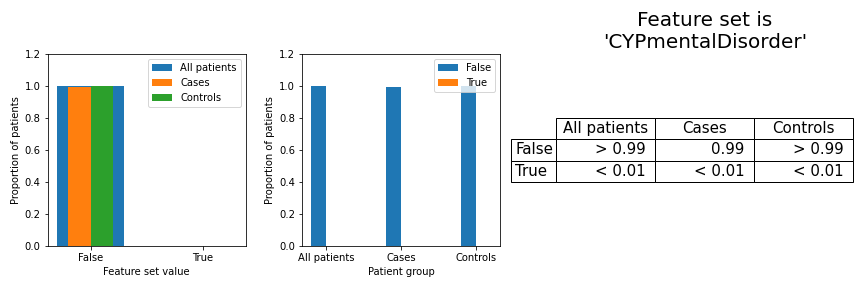

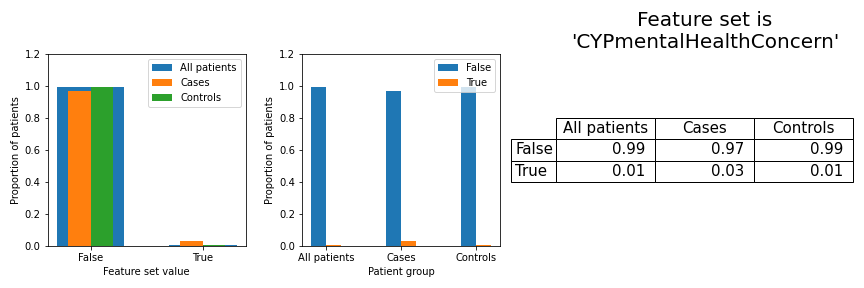

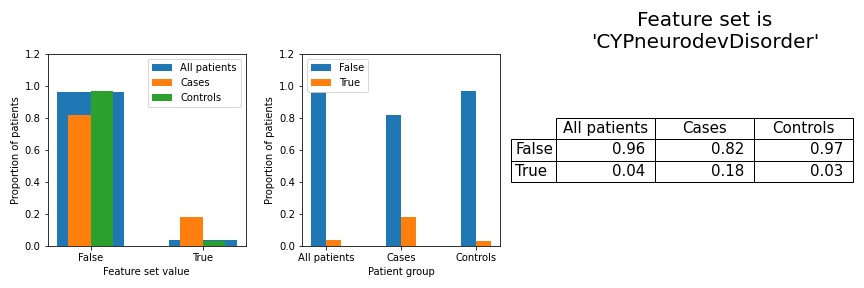

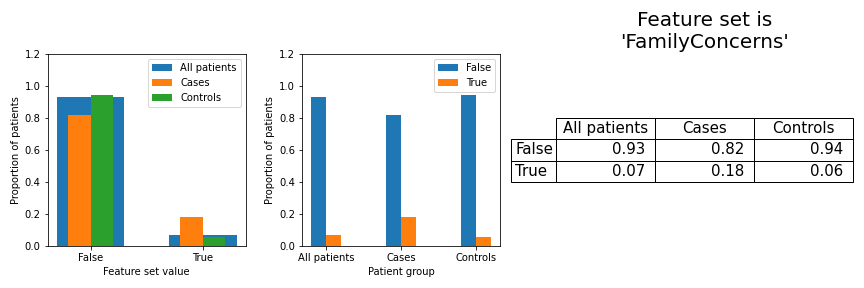

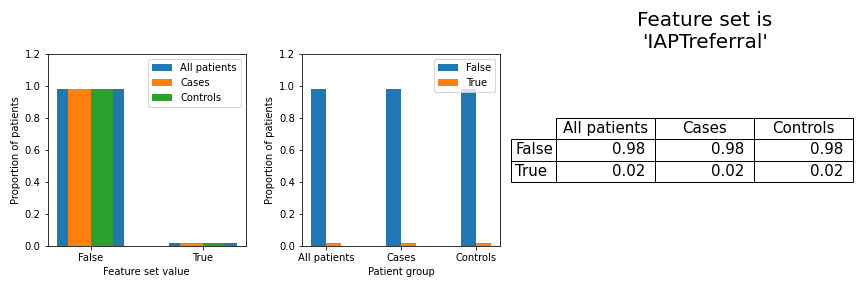

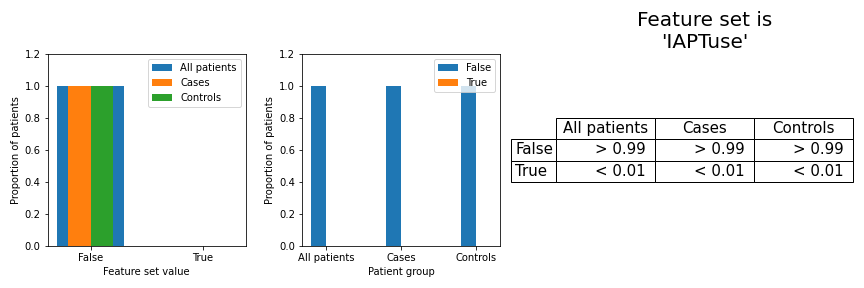

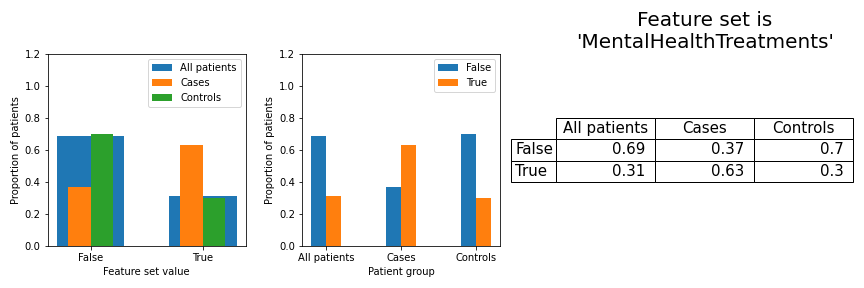

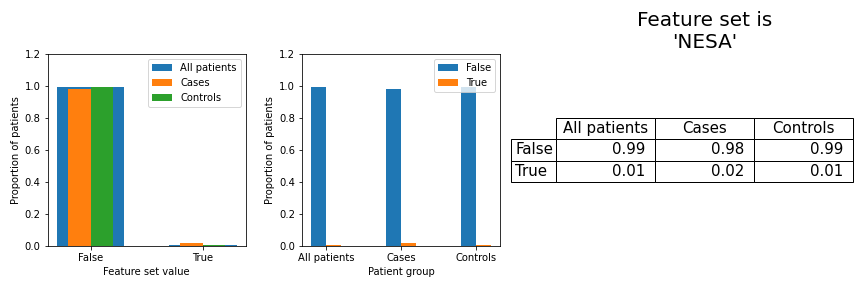

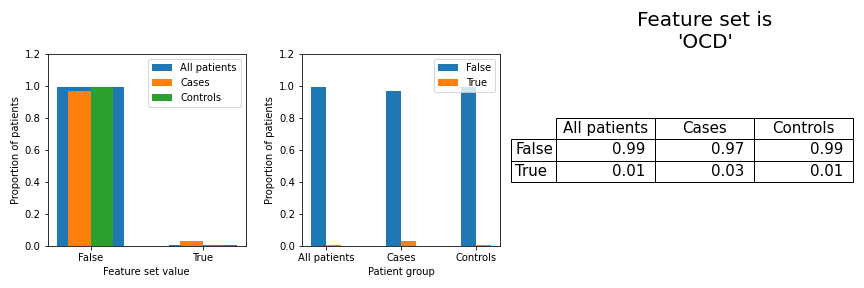

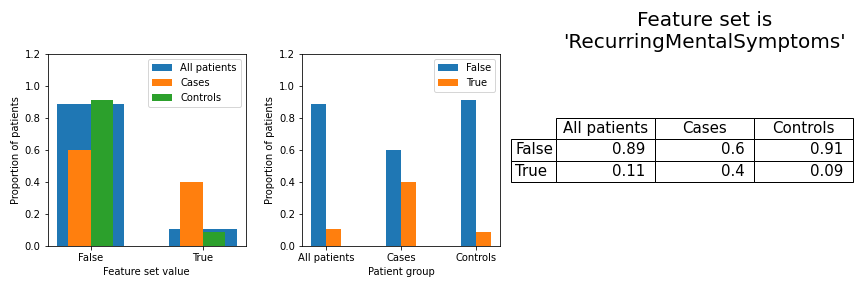

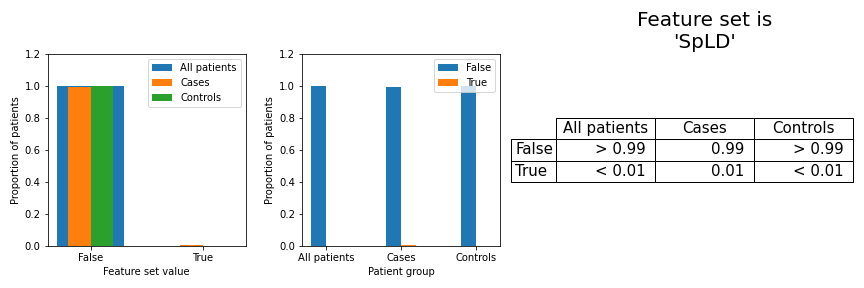

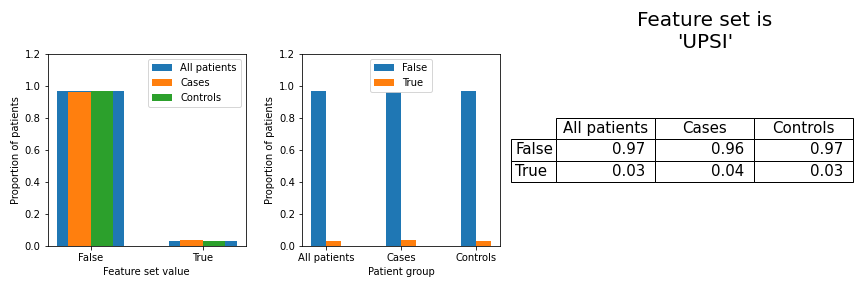

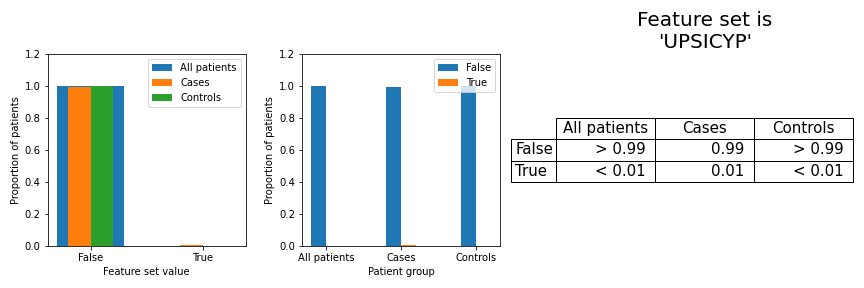

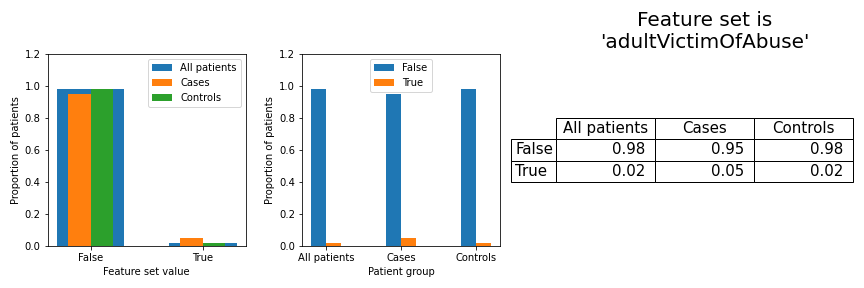

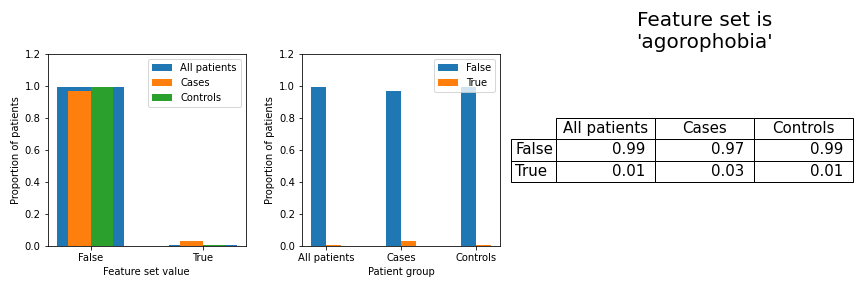

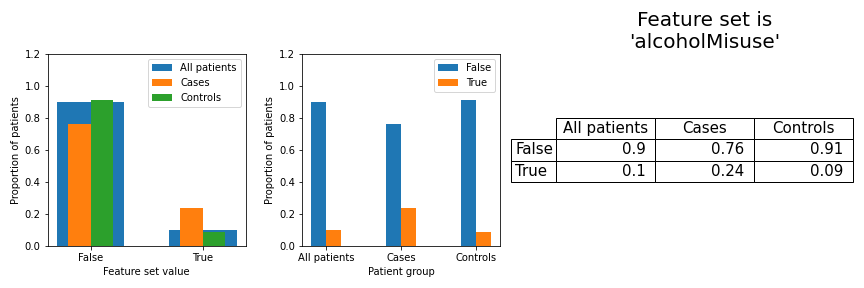

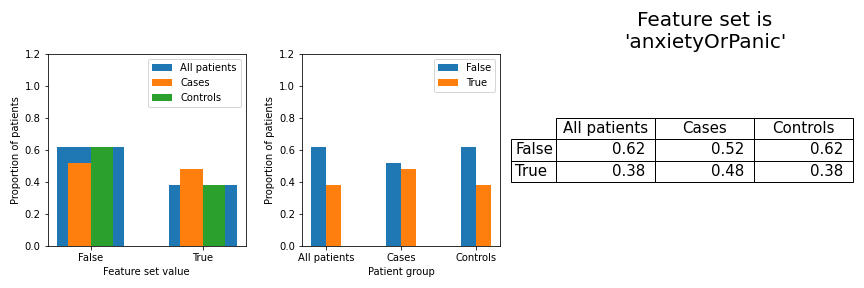

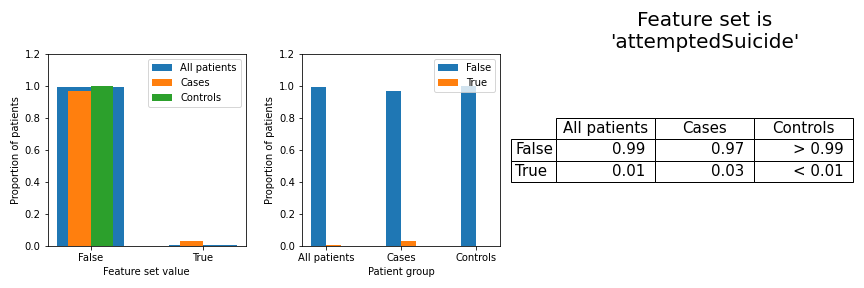

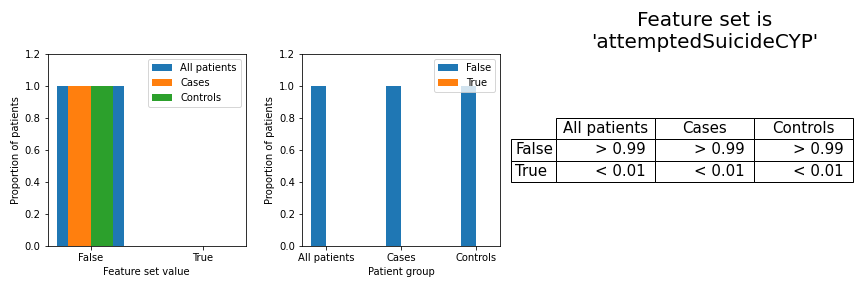

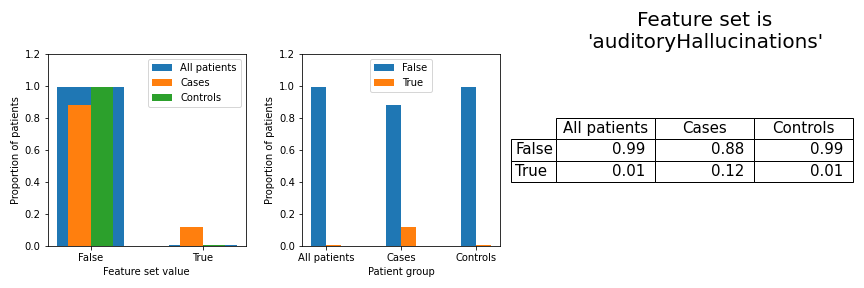

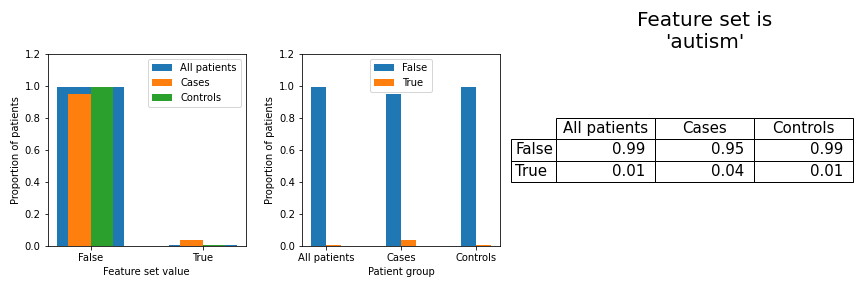

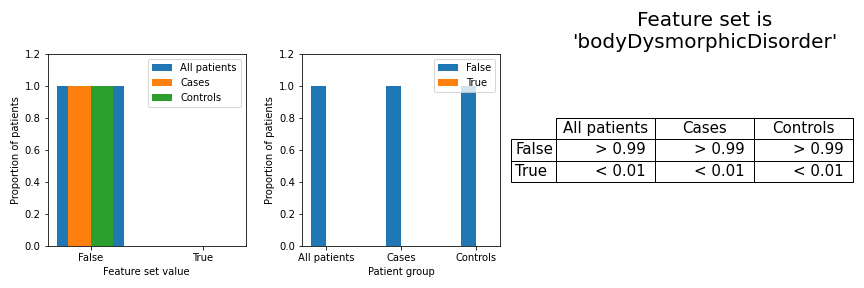

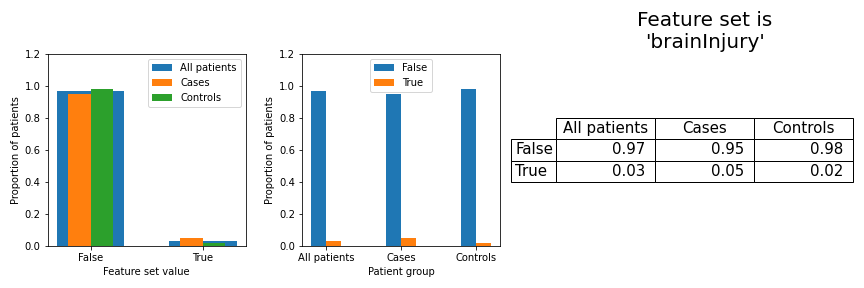

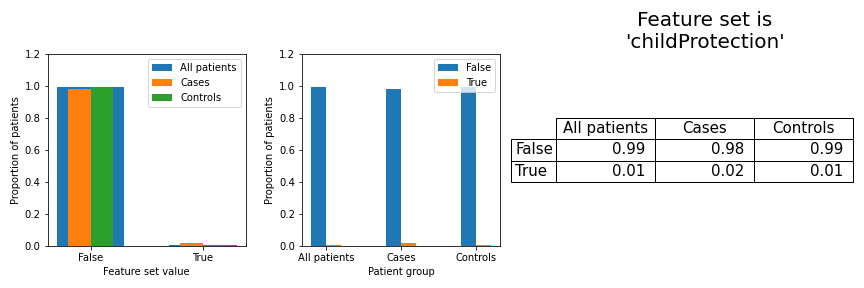

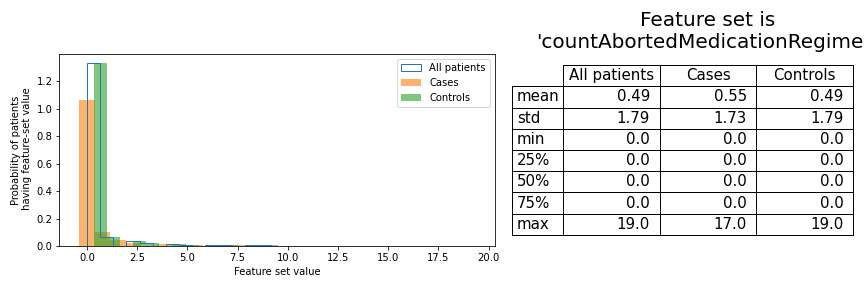

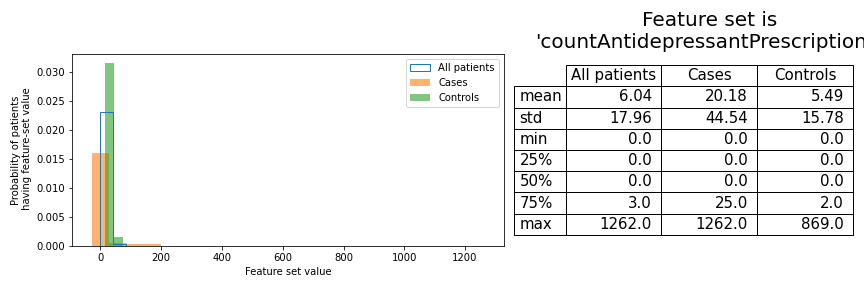

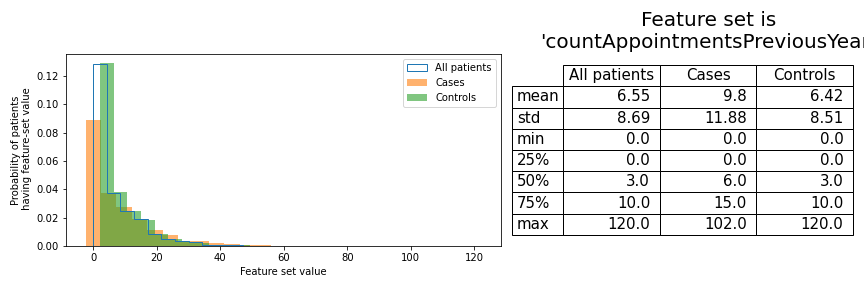

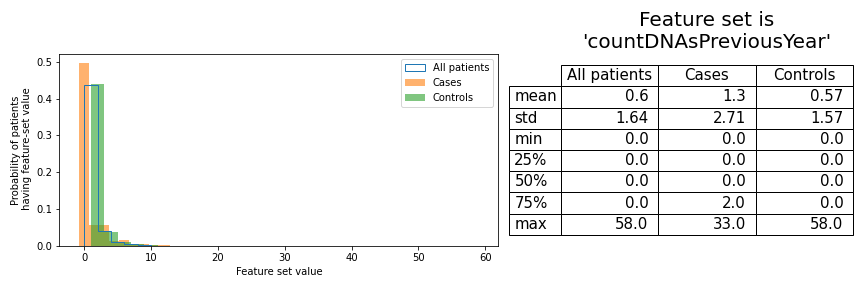

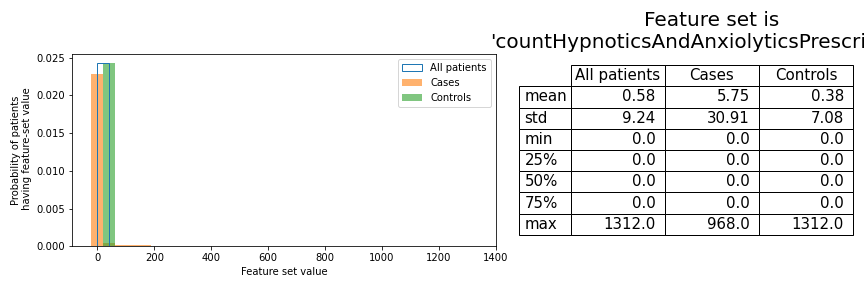

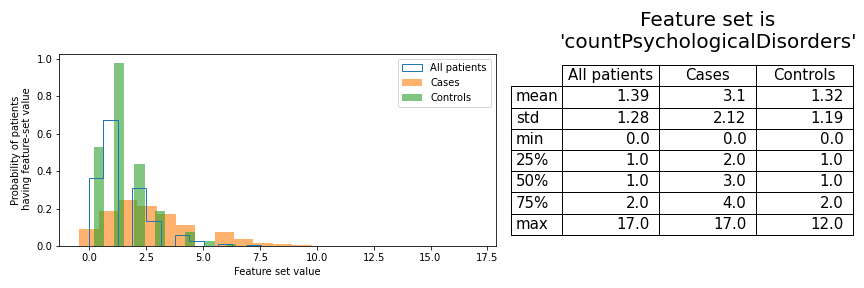

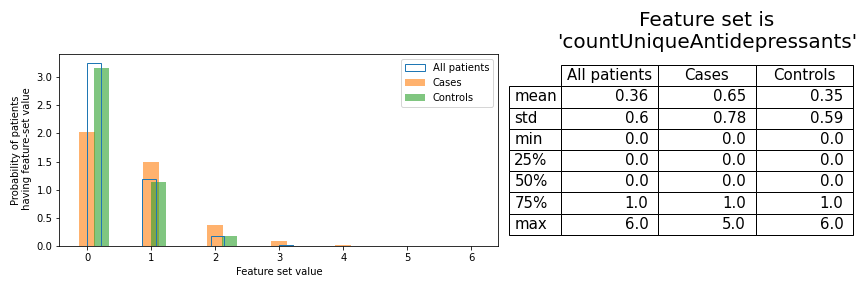

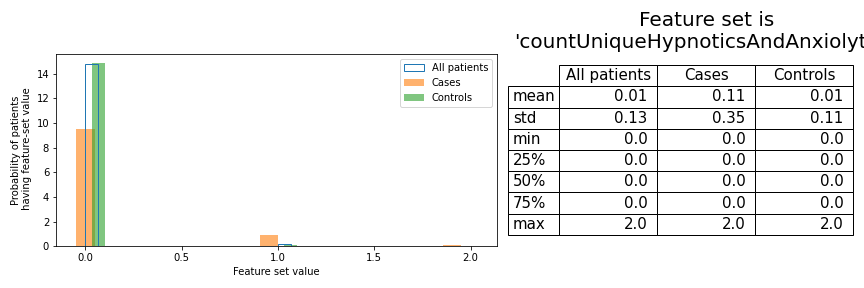

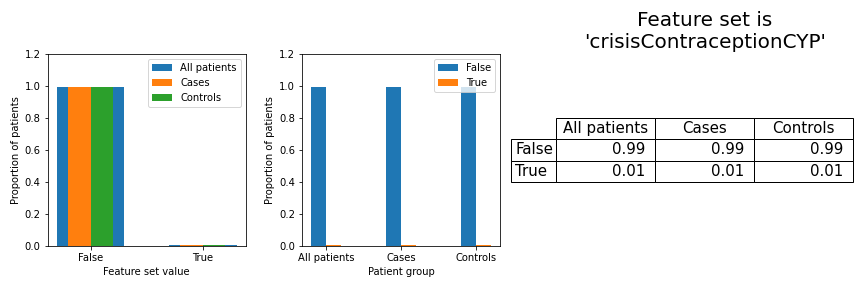

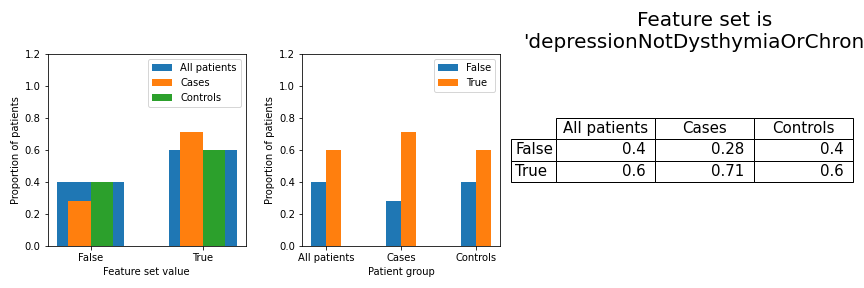

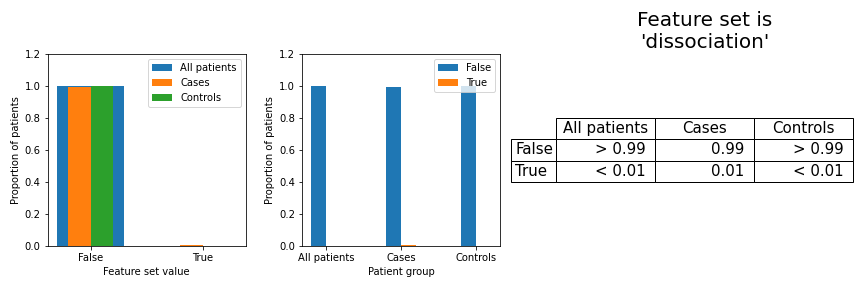

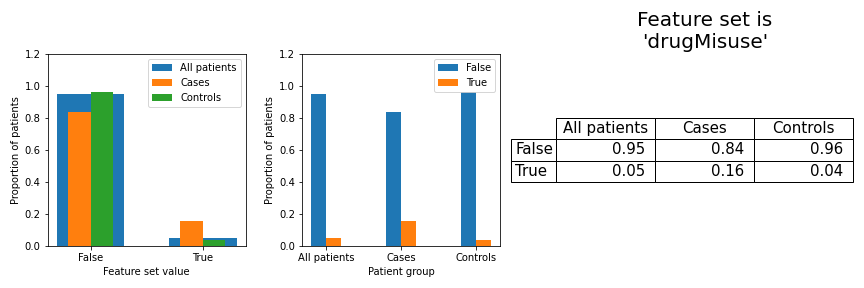

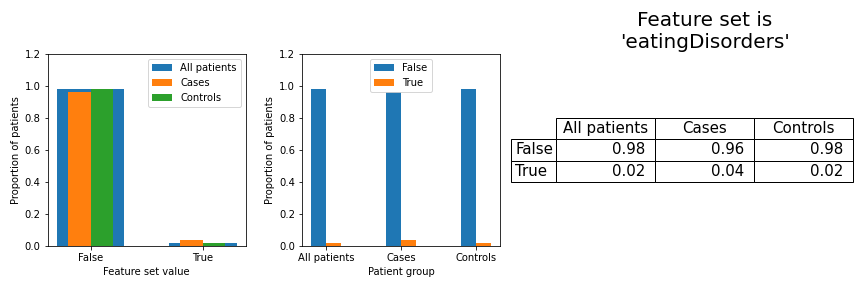

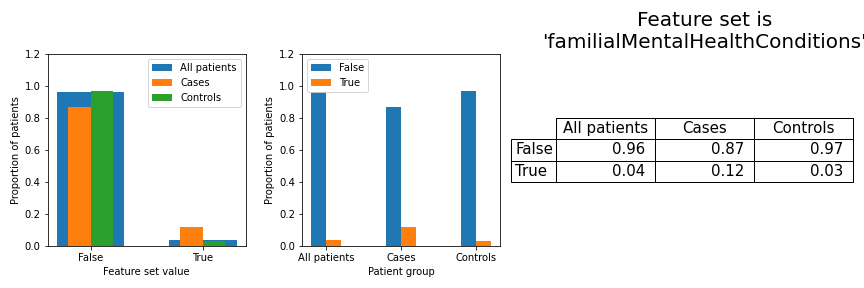

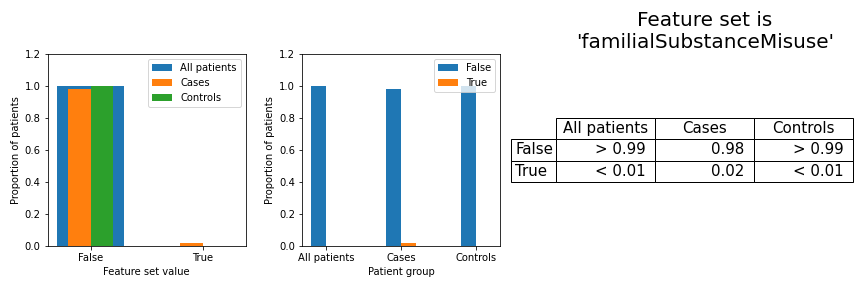

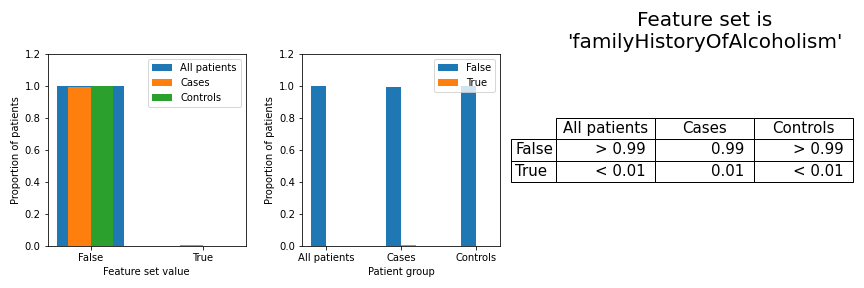

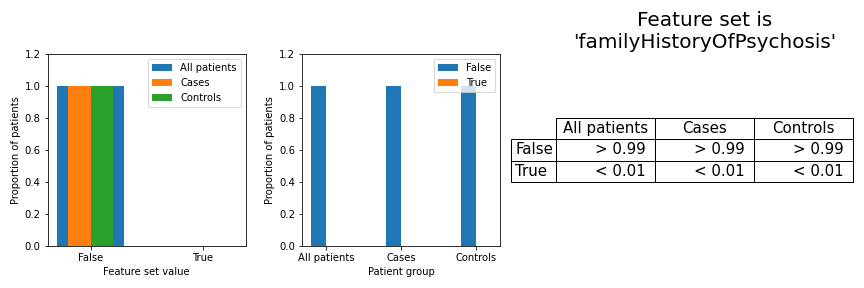

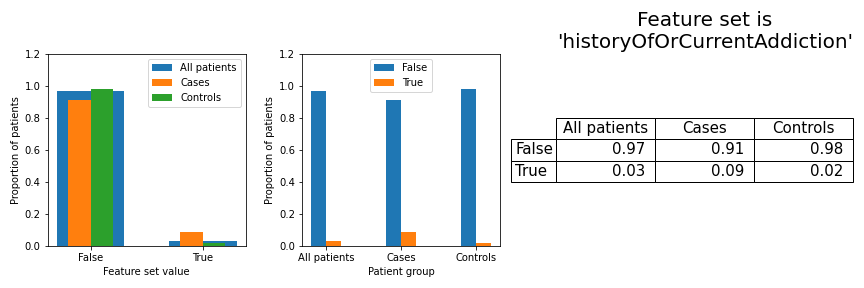

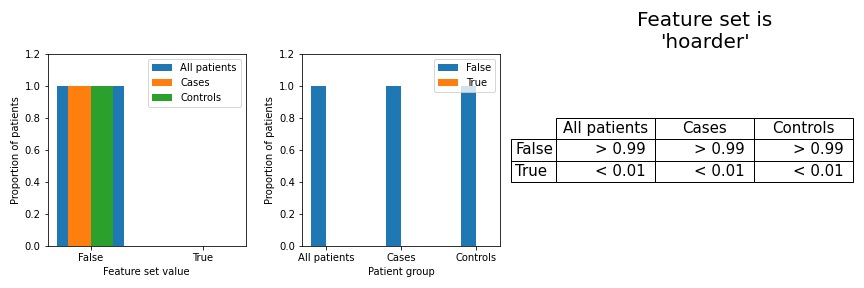

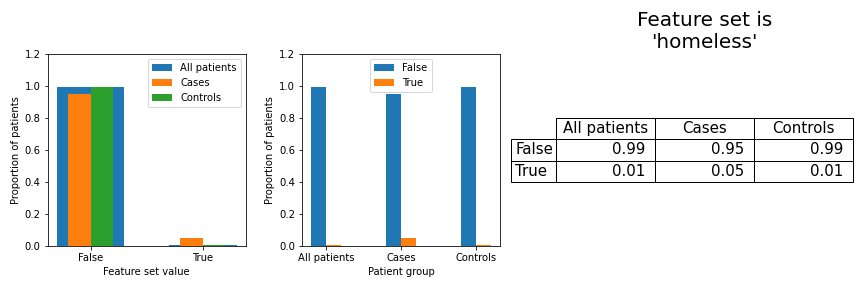

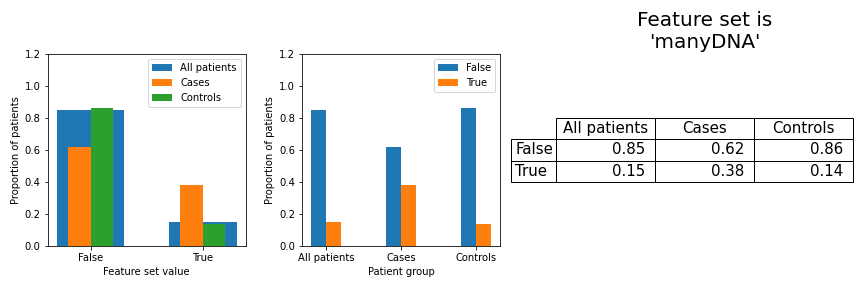

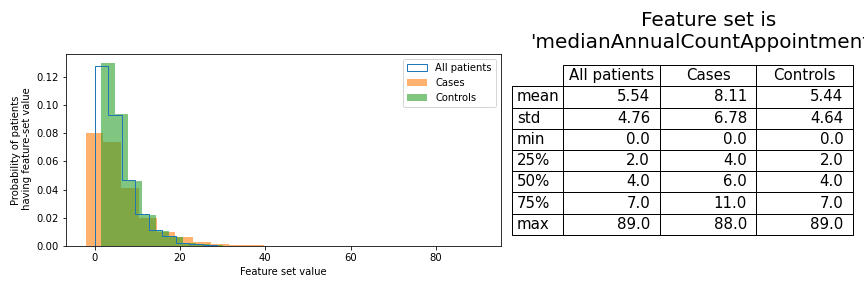

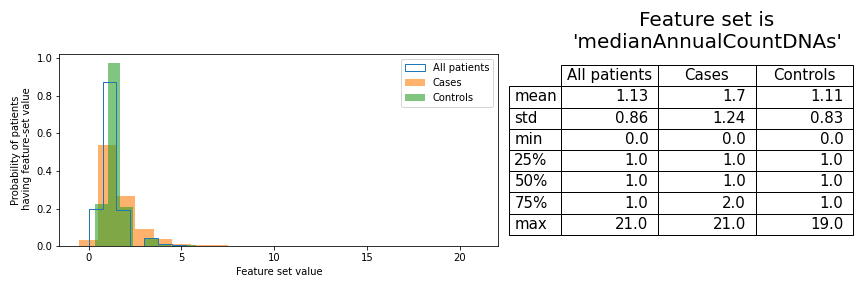

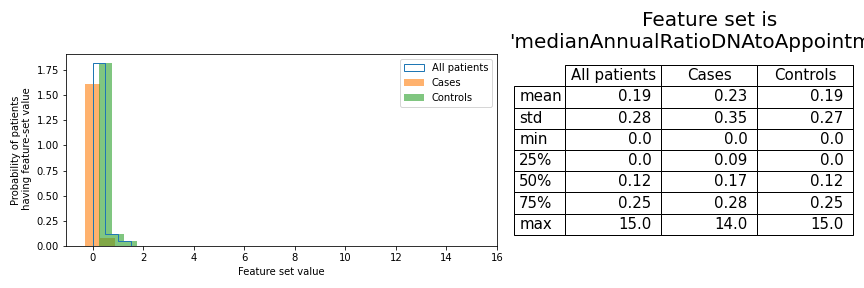

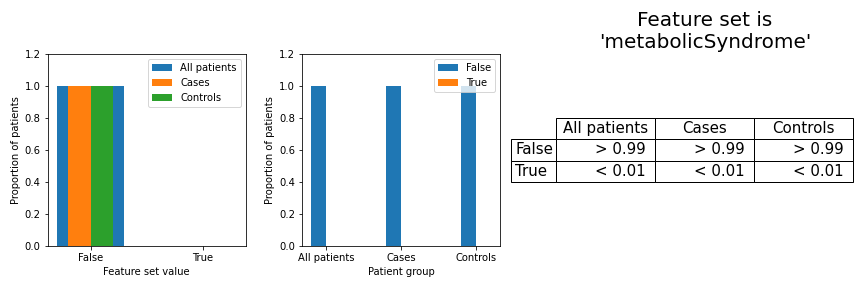

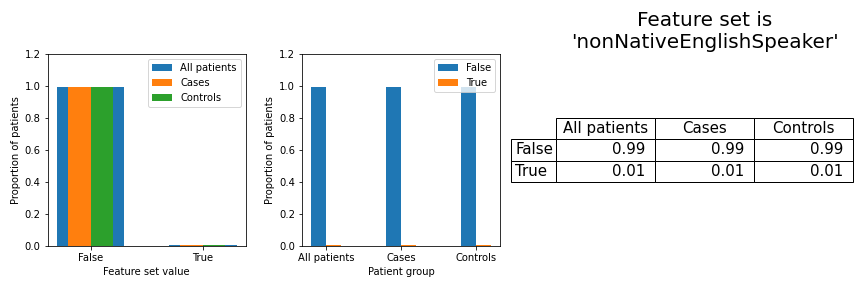

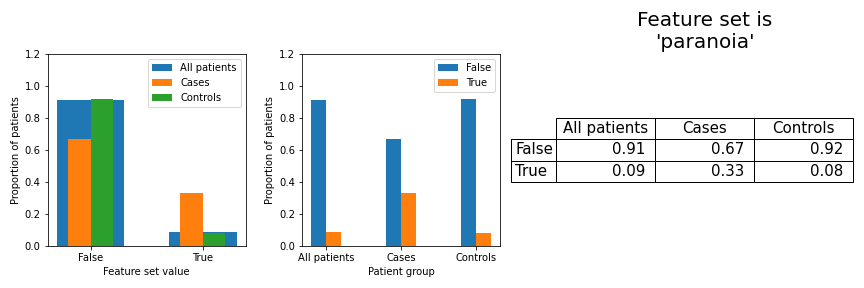

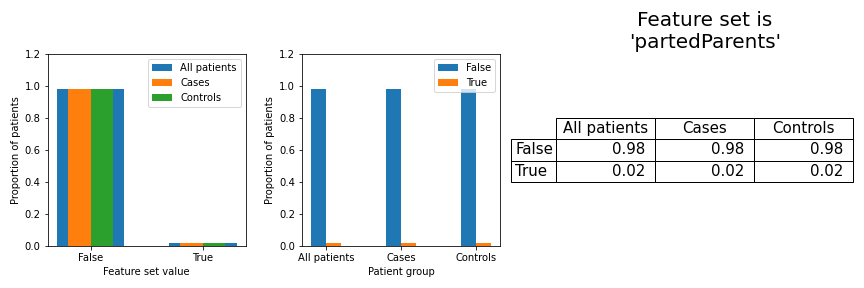

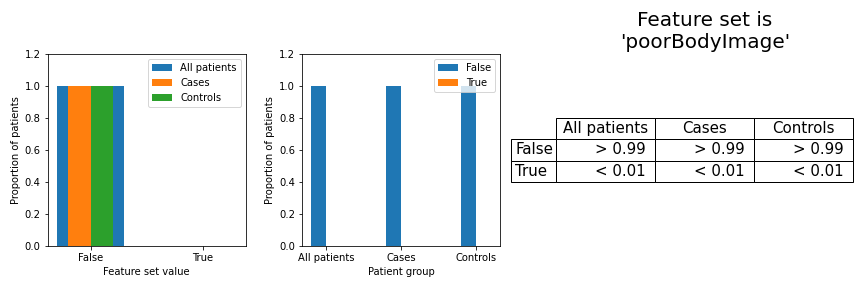

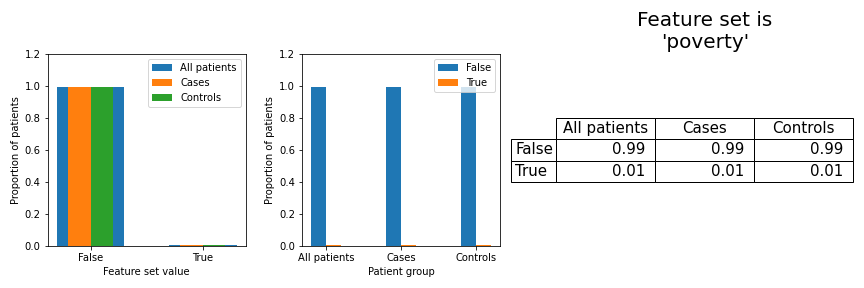

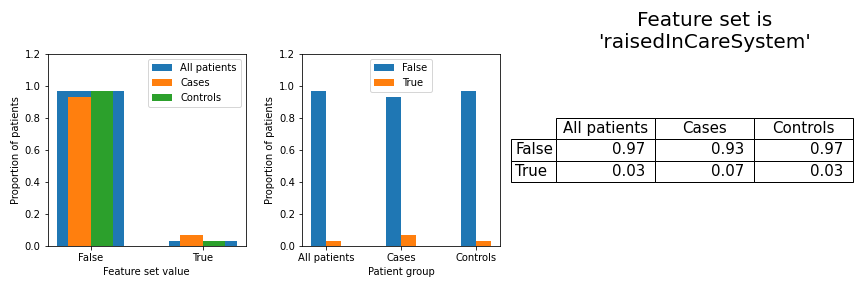

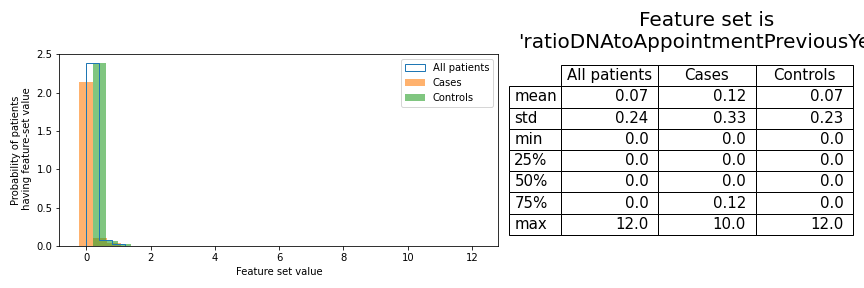

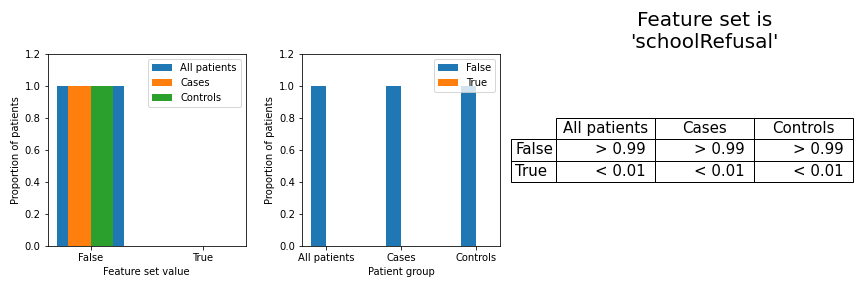

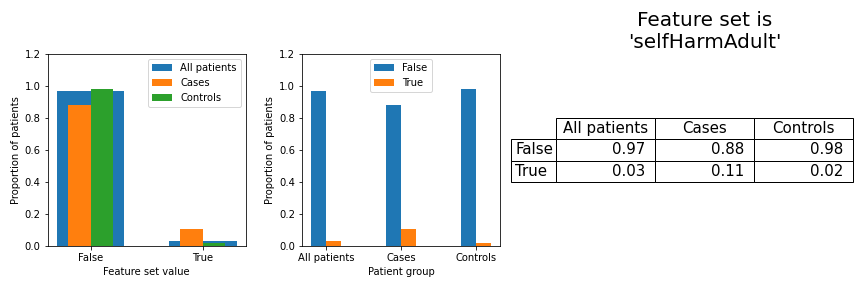

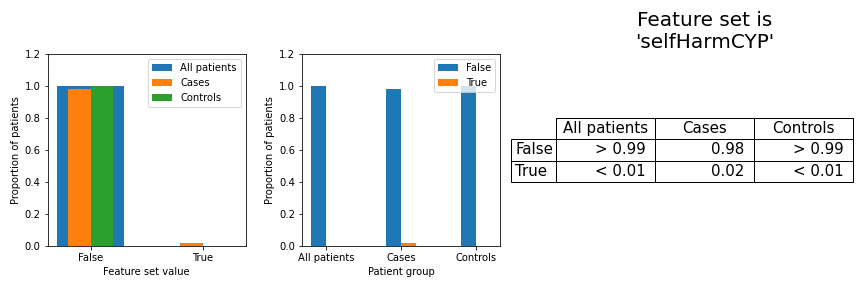

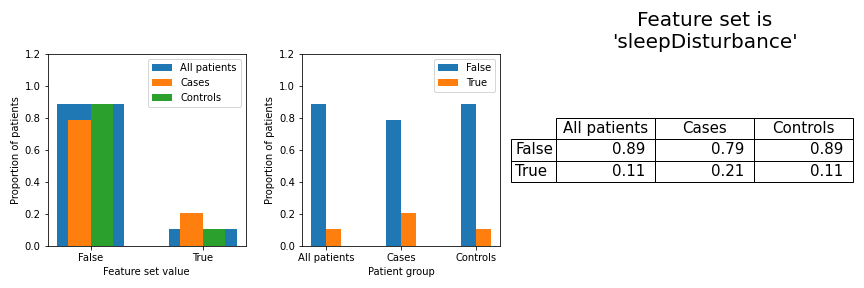

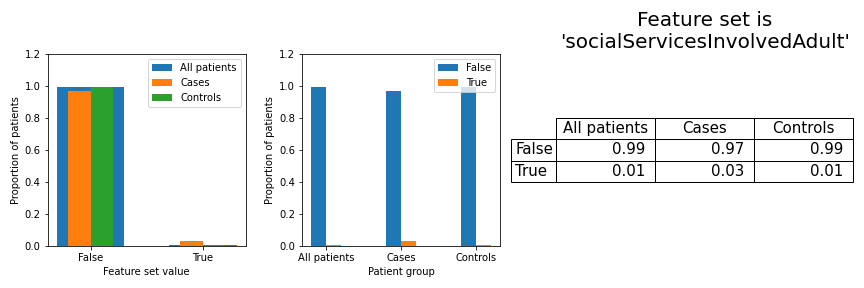

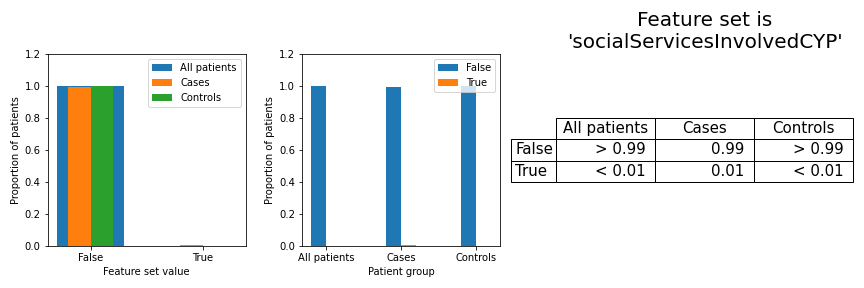

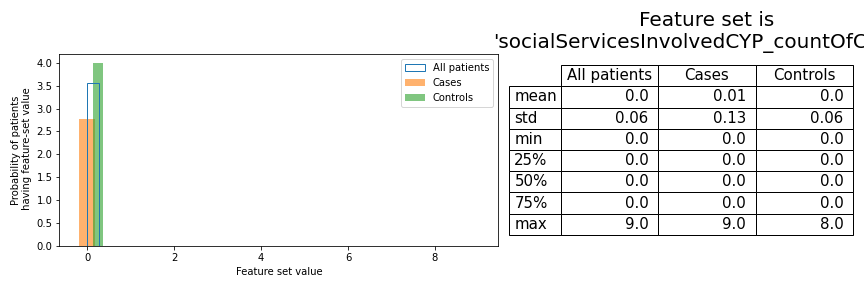

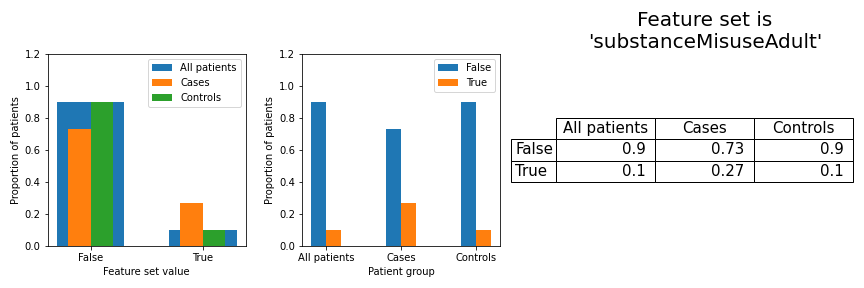

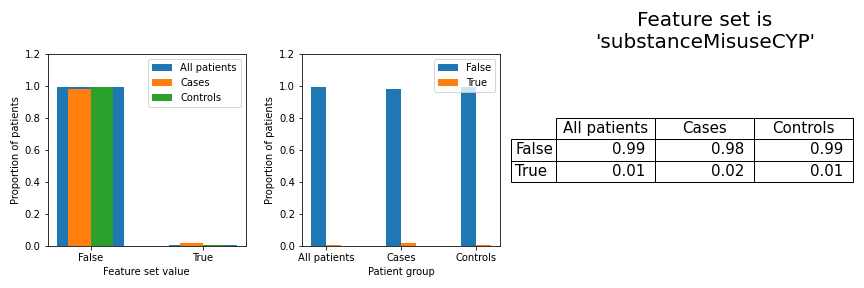

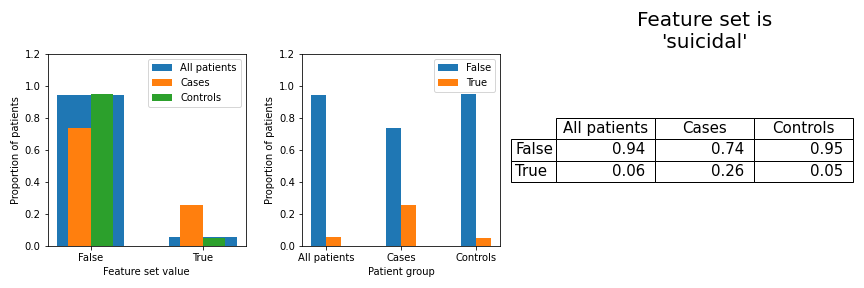

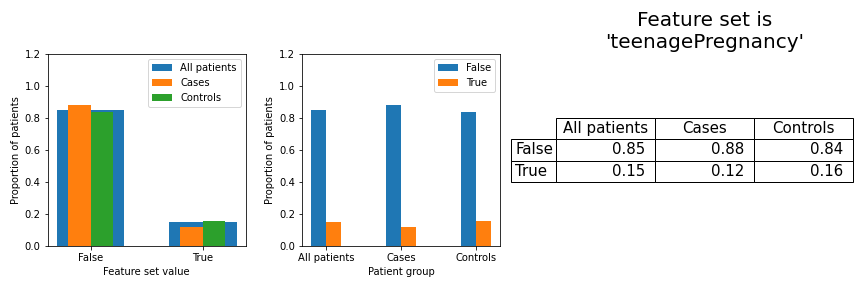

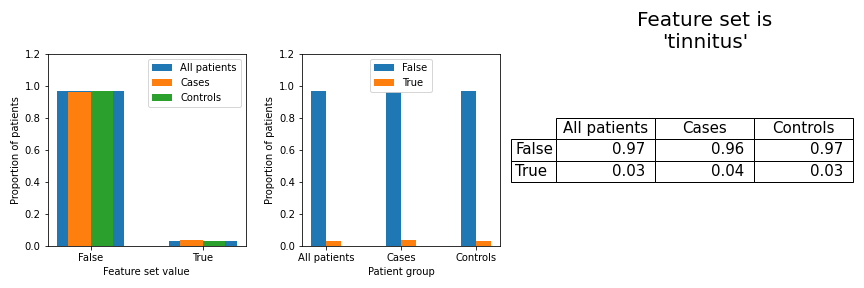

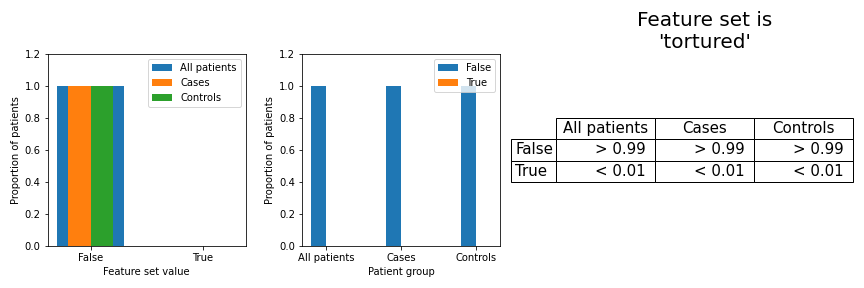

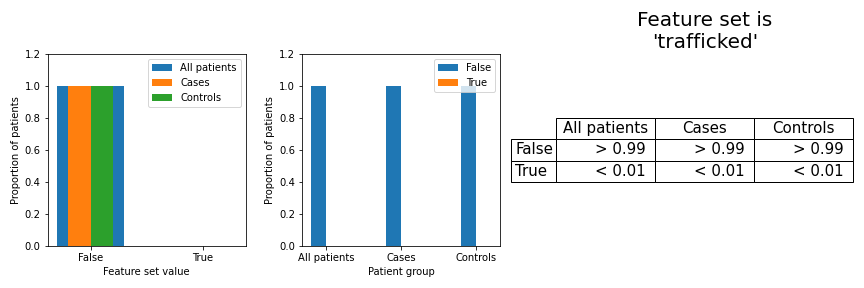

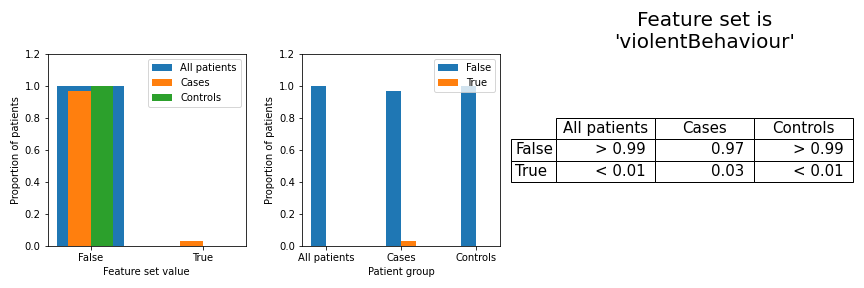

In [214]:
# Create a list of all relevant files.
globbed_files = plot_dir.glob("*.png")
globbed_files = sorted(globbed_files)
# Plot each file.
for image_file in globbed_files:
    display(Image(filename=image_file))